In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
import IPython.display as display
import time
from PIL import Image

## Uploading file manually

In [2]:
from google.colab import files
uploaded = files.upload()

data = np.load('cropped_03ded186-0f82-41ca-aad6-c071fded0b82_0.npy', allow_pickle=True)

Saving cropped_03ded186-0f82-41ca-aad6-c071fded0b82_0.npy to cropped_03ded186-0f82-41ca-aad6-c071fded0b82_0.npy


In [3]:
# See type and shape
print(type(data))
try:
    print(data.shape)
except:
    pass

<class 'numpy.ndarray'>
(122, 17, 3)


In [4]:
!git clone https://github.com/TaatiTeam/MotionAGFormer.git
%cd MotionAGFormer

Cloning into 'MotionAGFormer'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 155 (delta 22), reused 17 (delta 17), pack-reused 125 (from 1)
Receiving objects: 100% (155/155), 8.82 MiB | 22.40 MiB/s, done.
Resolving deltas: 100% (55/55), done.
/content/MotionAGFormer


In [5]:
os.makedirs("pose_frames", exist_ok=True)

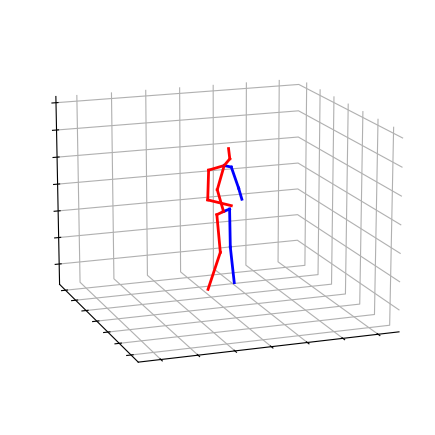

In [6]:
def show3Dpose(vals, ax):
    ax.view_init(elev=15., azim=70)

    lcolor=(0,0,1)
    rcolor=(1,0,0)

    I = np.array( [0, 0, 1, 4, 2, 5, 0, 7,  8,  8, 14, 15, 11, 12, 8,  9])
    J = np.array( [1, 4, 2, 5, 3, 6, 7, 8, 14, 11, 15, 16, 12, 13, 9, 10])

    LR = np.array([0, 1, 0, 1, 0, 1, 0, 0, 0,   1,  0,  0,  1,  1, 0, 0], dtype=bool)

    for i in np.arange( len(I) ):
        x, y, z = [np.array( [vals[I[i], j], vals[J[i], j]] ) for j in range(3)]
        ax.plot(x, y, z, lw=2, color = lcolor if LR[i] else rcolor)

    RADIUS = 0.72
    RADIUS_Z = 0.7
    xroot, yroot, zroot = vals[0,0], vals[0,1], vals[0,2]
    ax.set_xlim3d([-RADIUS+xroot, RADIUS+xroot])
    ax.set_ylim3d([-RADIUS+yroot, RADIUS+yroot])
    ax.set_zlim3d([-RADIUS_Z+zroot, RADIUS_Z+zroot])
    ax.set_aspect('auto')

    white = (1.0, 1.0, 1.0, 0.0)
    ax.xaxis.set_pane_color(white)
    ax.yaxis.set_pane_color(white)
    ax.zaxis.set_pane_color(white)

    ax.tick_params('x', labelbottom = False)
    ax.tick_params('y', labelleft = False)
    ax.tick_params('z', labelleft = False)

# Plot frame 0
fig = plt.figure(figsize=(9.6, 5.4))
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0], projection='3d')
show3Dpose(data[0], ax)
plt.show()


In [7]:
for i, frame in enumerate(data):
    fig = plt.figure(figsize=(6, 6))
    gs = gridspec.GridSpec(1, 1)
    ax = plt.subplot(gs[0], projection='3d')
    show3Dpose(frame, ax)
    plt.savefig(f"pose_frames/{i:04d}.png", dpi=100, bbox_inches='tight')
    plt.close(fig)

In [8]:
# Get frame size from first image
img = cv2.imread("pose_frames/0000.png")
height, width, layers = img.shape
video = cv2.VideoWriter("pose_video.mp4", cv2.VideoWriter_fourcc(*'mp4v'), 20, (width, height))

for i in range(len(data)):
    img = cv2.imread(f"pose_frames/{i:04d}.png")
    video.write(img)

video.release()
print("Video saved!")

Video saved!


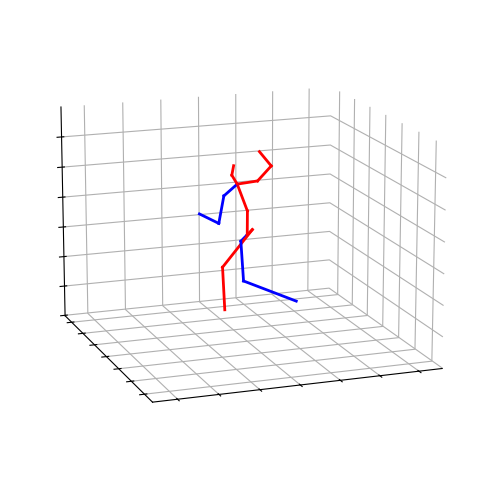

In [9]:
# Display each frame with a small delay (e.g. 0.05s)
for i in range(len(data)):
    frame_path = f"pose_frames/{i:04d}.png"
    img = Image.open(frame_path)
    display.display(img)
    time.sleep(0.02)
    display.clear_output(wait=True)

In [10]:
from google.colab import files
files.download("pose_video.mp4")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Connecting to S3 bucket

In [11]:
import boto3
import getpass

aws_access_key_id = getpass.getpass('Enter AWS Access Key ID: ')
aws_secret_access_key = getpass.getpass('Enter AWS Secret Access Key: ')

s3 = boto3.client('s3',
                  aws_access_key_id=aws_access_key_id,
                  aws_secret_access_key=aws_secret_access_key)

ModuleNotFoundError: No module named 'boto3'